# Udacity Finding Lane Lines Project

     #In this project we are asked to use the techniques taught in self-driving car nano-degree program to find lane lines initially from a series of images, and then on videos (which are sequence of images).

      # Importing Packages  

In [145]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [146]:
 # Helper Functions

In [170]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
    
# Below is a function used to draw two lanes from an image
def draw_lane_lines(img, lines, color=[255, 0, 0], thickness=12):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    left_points_x = [] # list to store x coordinates of left lane line
    left_points_y = [] # list to store y coordinates of left lane line
    right_points_x = [] # list to store x coordinates of right lane line
    right_points_y = [] # list to store y coordinates of right lane line
       
        
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (y1 == y2) or (x1==x2): # avoiding cases where slope could become zero or infinite
                continue               # i.e, avoiding horizontal and vertical lines
                
            slope = (y2-y1)/(x2-x1)# Slope
            #center = [(x2+x1)/2, (y2+y1)/2]
            
            # Collecting points on right line and left line using slope
            if slope>0:
                right_points_x.append(x1)
                right_points_y.append(y1)
                right_points_x.append(x2)
                right_points_y.append(y2)   
            else:
                left_points_x.append(x1)
                left_points_y.append(y1)
                left_points_x.append(x2)
                left_points_y.append(y2)
    
    draw_lane(img, left_points_x, left_points_y, color, thickness)
    draw_lane(img, right_points_x, right_points_y, color, thickness)

def draw_lane(img, X, Y, color, thickness):

     #If there is no 
    if len(X)==0 or len(Y) == 0 :
        return
    
    # Using polyfit to obtain coefficients of single order equation formed from X and Y, 
    #which are slope and intercepts
    line_m_c = np.polyfit(X,Y,1)
    
    m = line_m_c[0] #Slope
    c = line_m_c[1] #Intercept
    
    Y1 = img.shape[0] # bottom of the image
    Y2 = Y1/2 + 60 # around middle of the image
    
    # Obtaining the coordinates of line using equation y=m*x + c
    # Also converting them to int's so that they are compatible with cv2.line input parameters
    y1 = int(Y1)
    y2 = int(Y2)
    x1 = int((Y1 - c)/m)
    x2 = int((Y2 - c)/m)
   # Drawing line 
    cv2.line(img, (x1,y1), (x2,y2), color, thickness)
    
      

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, image):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    return lines,line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)




Loading images from test directory

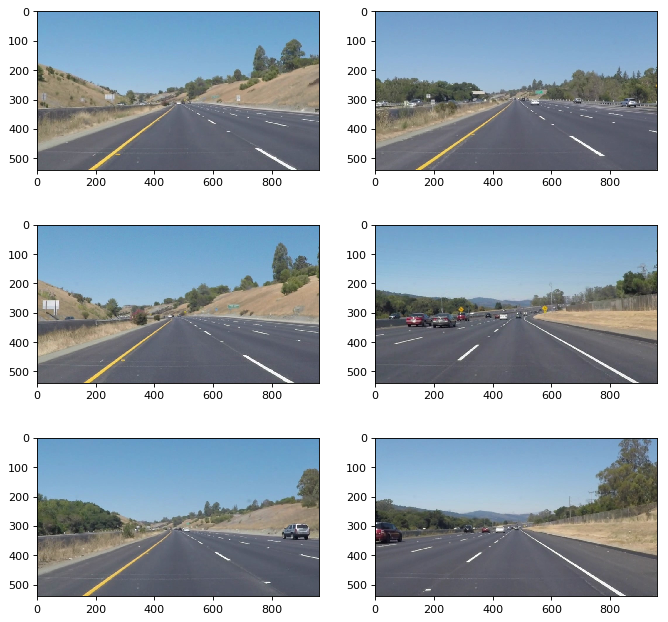

In [171]:
import os
os.listdir("test_images/")

#reading all images from folder and plotting them
plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = mpimg.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

images = load_images("test_images/")

cols = 2
rows = (len(images)+1)/cols
for i,image in enumerate(images):
    plt.subplot(rows,cols,i+1)
    plt.imshow(image)
    

Below is the pipeline that will draw lane lines on the test_images

In [172]:
def draw_lanes_pipeline(image):

    #Obtaining gray image
    gray_image = grayscale(image)
    # Choose odd positive kernel size
    kernel_size = 15
    # Obtaining a smoothened image by 
    #running gray image through gaussian filter
    smoothened_image = gaussian_blur(gray_image,kernel_size)
    #Choosing low and high thresholds to detect canny edges
    low_threshold = 70
    high_threshold = 140
    canny_edges_image = canny(smoothened_image, low_threshold, high_threshold)
    
    #Defining vertices for region of interest polygon
    bottom_left = [150, 550]
    bottom_right = [950, 550]
    top_right = [640, 360]
    top_left = [360, 360]
    vertices = np.array([[bottom_left, bottom_right, top_right, top_left]], dtype=np.int32)
    # Obtaining region of interest
    ROI_image = region_of_interest(canny_edges_image, vertices)

    # Define the Hough transform parameters
    rho = 1
    theta = np.pi/180
    threshold = 30
    min_line_length = 30
    max_line_gap = 200
    line_image = np.copy(image)*0 #creating a blank to draw lines on

    # Run Hough transform on edge detected image
    lines,line_img = hough_lines(ROI_image, rho, theta, threshold, min_line_length, max_line_gap, image)
    #Drawing both left and right lane lines
    draw_lane_lines(line_img, lines)
    #Drawing lanes on original image
    lines_original = weighted_img(line_img, image)   
    return lines_original


Looping all images in test directory to draw lanes on each image by calling above pipeline for each image

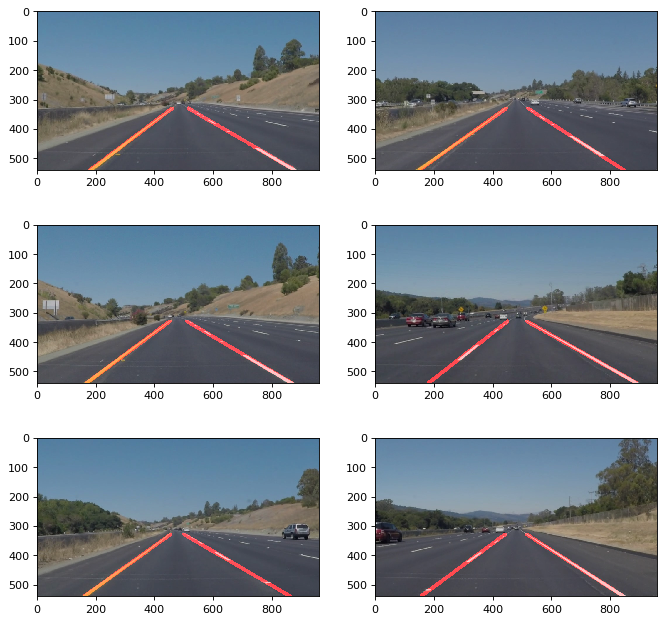

In [173]:
plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

images = load_images("test_images/")

cols = 2
rows = (len(images)+1)/cols
for i,image in enumerate(images):
    plt.subplot(rows,cols,i+1)
    plt.imshow(draw_lanes_pipeline(image))
               

Test on Videos

In [174]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [175]:
def process_image(image):
    
    #plt.imshow(image)
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    orig_image = draw_lanes_pipeline(image)
    #plt.imshow(draw_lanes_pipeline(image))
    return orig_image

Let's try the one with the solid white lane on the right first ...

In [176]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))


[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



100%|█████████▉| 221/222 [00:14<00:00, 15.14it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.28 s, sys: 298 ms, total: 3.58 s
Wall time: 16.3 s


In [177]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



 94%|█████████▍| 641/682 [00:45<00:02, 13.81it/s]


100%|█████████▉| 681/682 [00:48<00:00, 13.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 9.91 s, sys: 930 ms, total: 10.8 s
Wall time: 49.9 s


Optional Challenge

In [178]:

def challenge_draw_lanes_pipeline(image):

    #Obtaining gray image
    gray_image = grayscale(image)
    # Choose a odd kernel size
    kernel_size = 13
    # Obtaining a smoothened image by 
    #running original image through gaussian filter
    smoothened_image = gaussian_blur(gray_image,kernel_size)
    #Choosing low and high thresholds to detect canny edges
    low_threshold = 70
    high_threshold = 140
    canny_edges_image = canny(smoothened_image, low_threshold, high_threshold)
    
    #Defining vertices for region of interest polygon
    height,width = image.shape[:2]
    bottom_left = [width*0.1, height*0.95]
    bottom_right = [width*0.9, height*0.9]
    top_right = [width*0.8, height*0.6]
    top_left = [width*0.3, height*0.6]
    #print(height,width)
    #bottom_left = [400, 1200]
    #bottom_right = [1200, 1200]
    #top_right = [1000, 500]
    #top_left = [600, 500]
    vertices = np.array([[bottom_left, bottom_right, top_right, top_left]], dtype=np.int32)
    imshape = image.shape
    # Obtaining region of interest
    ROI_image = region_of_interest(canny_edges_image, vertices)

    # Define the Hough transform parameters
    rho = 1
    theta = np.pi/180
    threshold = 10
    min_line_length = 10
    max_line_gap = 200
    line_image = np.copy(image)*0 #creating a blank to draw lines on

    # Run Hough transform on edge detected image
    lines,line_img = hough_lines(ROI_image, rho, theta, threshold, min_line_length, max_line_gap, image)
    #Drawing both left and right lane lines
    draw_lane_lines(line_img, lines)
    #Drawing lanes on original image
    lines_original = weighted_img(line_img, image)   
    return lines_original


def challenge_process_image(image):
    
    #plt.imshow(image)
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    orig_image = challenge_draw_lanes_pipeline(image)
    #plt.imshow(draw_lanes_pipeline(image))
    return orig_image

challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(challenge_process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))


[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



100%|██████████| 251/251 [00:34<00:00,  7.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 6.58 s, sys: 591 ms, total: 7.17 s
Wall time: 38.4 s
